# Part 0

In [12]:
# 0. Import Libraries and Load Dataset

# Data analysis and visualization packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import IsolationForest
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
data_path = "/content/drive/MyDrive/EFIplus_medit.csv"
df = pd.read_csv(data_path, sep=';')

# Standardize column names
df.columns = df.columns.str.strip().str.lower()

# Confirm load
print(" Columns loaded:", df.columns.tolist())
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Columns loaded: ['site_code', 'latitude', 'longitude', 'country', 'catchment_name', 'galiza', 'subsample', 'calib_efi_medit', 'calib_connect', 'calib_hydrol', 'calib_morphol', 'calib_wqual', 'geomorph1', 'geomorph2', 'geomorph3', 'water_source_type', 'flow_regime', 'altitude', 'geological_typology', 'actual_river_slope', 'natural_sediment', 'elevation_mean_catch', 'prec_ann_catch', 'temp_ann', 'temp_jan', 'temp_jul', 'barriers_catchment_down', 'barriers_river_segment_up', 'barriers_river_segment_down', 'barriers_number_river_segment_up', 'barriers_number_river_segment_down', 'barriers_distance_river_segment_up', 'barriers_distance_river_segment_down', 'impoundment', 'hydropeaking', 'water_abstraction', 'hydro_mod', 'temperature_impact', 'velocity_increase', 'reservoir_flushing', 'sedimentation', 'channelisation', 'cross_sec', 'instream_habitat', 'riparian_ve

,site_code,latitude,longitude,country,catchment_name,galiza,subsample,calib_efi_medit,calib_connect,calib_hydrol,...,squalius malacitanus,squalius pyrenaicus,squalius torgalensis,thymallus thymallus,tinca tinca,zingel asper,squalius sp,barbatula sp,phoxinus sp,iberochondrostoma_sp
0,ES_01_0002,38.102003,-4.096070,Spain,Guadalquivir,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,ES_02_0001,40.530188,-1.887796,Spain,Tejo,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,ES_02_0002,40.595432,-1.928079,Spain,Tejo,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,ES_02_0003,40.656184,-1.989831,Spain,Tejo,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,ES_02_0004,40.676402,-2.036274,Spain,Tejo,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


# Part 1


<ipython-input-13-252eb9390697>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['richness'] = df[species_columns].sum(axis=1)


 Species richness column created.


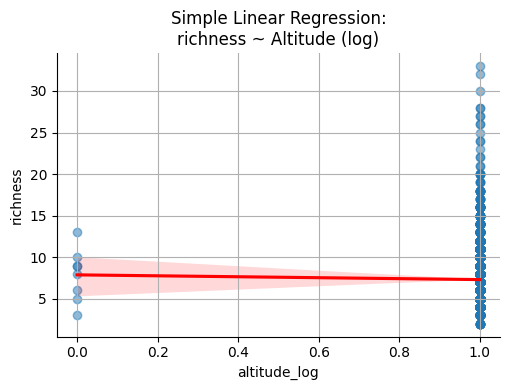

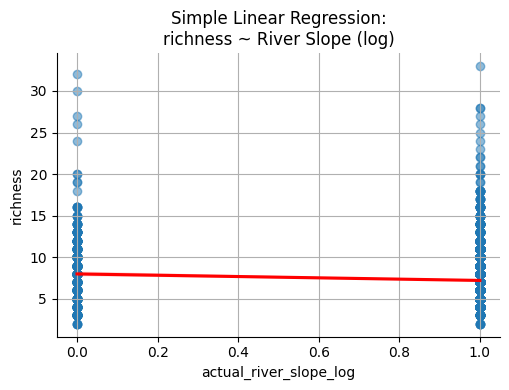

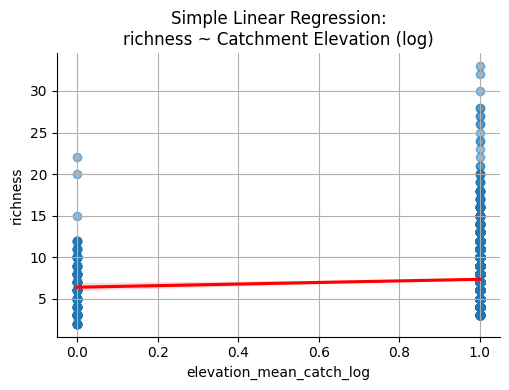

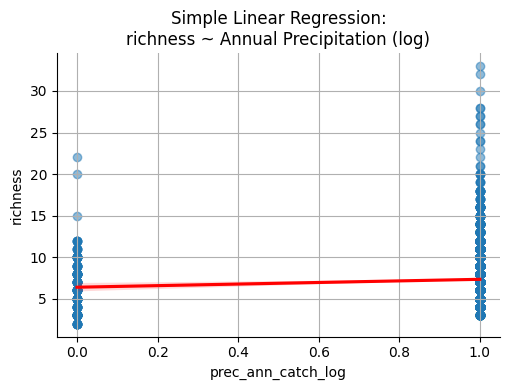

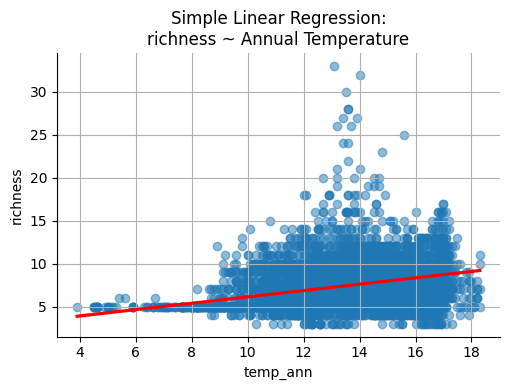

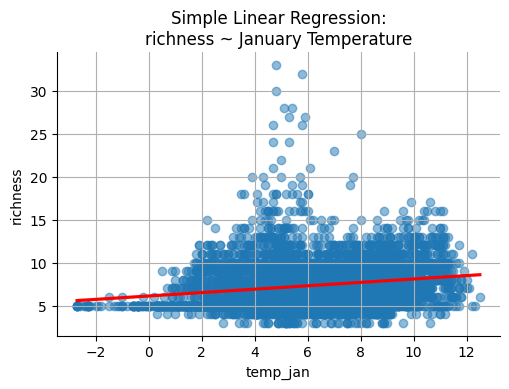

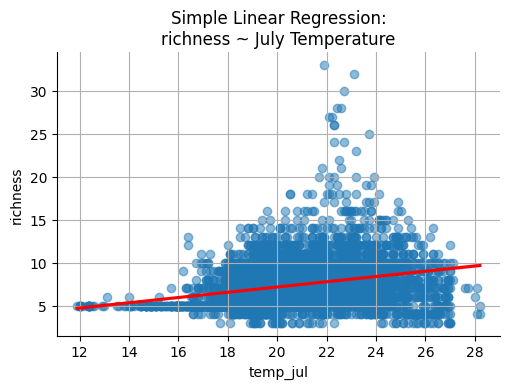

In [13]:
# 1. Simple Linear Regressions: richness ~ one predictor at a time

import statsmodels.api as sm
import statsmodels.formula.api as smf

# --- Ensure log-transformed variables exist ---
log_transform_vars = ['altitude', 'actual_river_slope', 'elevation_mean_catch', 'prec_ann_catch']
for var in log_transform_vars:
    if var in df.columns and f"{var}_log" not in df.columns:
        df[f"{var}_log"] = np.log1p(df[var])

# --- Ensure 'richness' exists or calculate it ---
first_species = 'abramis brama'
if 'richness' not in df.columns and first_species in df.columns:
    start_index = df.columns.get_loc(first_species)
    species_columns = df.columns[start_index:]
    df[species_columns] = (df[species_columns] >= 1).astype(int)
    df['richness'] = df[species_columns].sum(axis=1)
    df = df.copy()  # Fix fragmentation
    print(" Species richness column created.")
elif 'richness' in df.columns:
    print(" 'richness' already exists.")
else:
    raise ValueError("❗ 'abramis brama' column not found to compute species richness.")

# --- Define response and predictors ---
response = 'richness'
predictors = {
    'altitude_log': 'Altitude (log)',
    'actual_river_slope_log': 'River Slope (log)',
    'elevation_mean_catch_log': 'Catchment Elevation (log)',
    'prec_ann_catch_log': 'Annual Precipitation (log)',
    'temp_ann': 'Annual Temperature',
    'temp_jan': 'January Temperature',
    'temp_jul': 'July Temperature'
}

# --- Run regressions and store results ---
univar_results = []

for var, label in predictors.items():
    if var in df.columns:
        try:
            formula = f"{response} ~ {var}"
            model = smf.ols(formula=formula, data=df).fit()

            univar_results.append({
                'Predictor': label,
                'β0 (Intercept)': round(model.params.iloc[0], 3),
                'β1 (Slope)': round(model.params.iloc[1], 3),
                'R²': round(model.rsquared, 3),
                'F-statistic': round(model.fvalue, 3),
                'p-value': round(model.f_pvalue, 4)
            })

            # Plot
            sns.lmplot(data=df, x=var, y='richness', height=4, aspect=1.3,
                       line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5})
            plt.title(f'Simple Linear Regression:\nrichness ~ {label}')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"❗ Error fitting model for {label}: {e}")
    else:
        print(f"⚠️ Skipped '{label}' because variable '{var}' is not in the dataframe.")



In [11]:
# --- Display summary table ---
univar_df = pd.DataFrame(univar_results)
print(" Summary of Simple Linear Regressions:")
display(univar_df)

 Summary of Simple Linear Regressions:


,Predictor,β0 (Intercept),β1 (Slope),R²,F-statistic,p-value
0,Altitude (log),7.904,-0.789,0.112,629.661,0.0
1,River Slope (log),5.778,-1.027,0.134,769.992,0.0
2,Catchment Elevation (log),10.175,-1.031,0.048,246.250,0.0
3,Annual Precipitation (log),11.649,-1.203,0.020,97.565,0.0
4,Annual Temperature,-1.913,0.406,0.095,510.891,0.0
5,January Temperature,2.109,0.219,0.042,211.159,0.0
6,July Temperature,-3.473,0.337,0.093,496.442,0.0


### Interpretation of Simple Linear Regressions

Each regression model estimates the effect of one environmental variable on **species richness**. Below is a summary of the main patterns observed:

---

#### Strongest Predictors (Highest R²)

- **River Slope (log)**
  - Slope (β₁) = **-1.027**
  - R² = **0.134**
  - This is the strongest individual predictor, explaining about 13.4% of the variance in species richness. There is a clear negative relationship — higher slopes are associated with lower richness.

- **Altitude (log)**
  - β₁ = **-0.789**, R² = **0.112**
  - Richness decreases with increasing altitude.

- **July Temperature**
  - β₁ = **+0.337**, R² = **0.093**
  - Richness increases with higher summer temperatures.

---

#### Weaker Predictors

- **Catchment Elevation (log):** R² = **0.048**
- **January Temperature:** R² = **0.042**
- **Annual Precipitation (log):** R² = **0.020**

Although these variables are statistically significant (p < 0.001), they explain a relatively small portion of the variability in species richness on their own.

---

#### Statistical Significance

- All predictors are **highly significant** (p < 0.001).
- However, significance alone does not imply strong predictive power — some predictors show small effect sizes despite being statistically relevant.

---






# Part 2

In [15]:
# 2. Multiple Linear Regression (Updated with Partial Dependence Plots)

# --- Define predictors (same as before) ---
multi_predictors = [
    'altitude_log',
    'actual_river_slope_log',
    'elevation_mean_catch_log',
    'prec_ann_catch_log',
    'temp_ann',
    'temp_jan',
    'temp_jul'
]

# --- Keep only variables that exist ---
existing_predictors = [var for var in multi_predictors if var in df.columns]
if len(existing_predictors) < len(multi_predictors):
    missing = list(set(multi_predictors) - set(existing_predictors))
    print(f"⚠️ Skipped missing predictors: {missing}")

# --- Fit model ---
formula_multi = "richness ~ " + " + ".join(existing_predictors)
multi_model = smf.ols(formula=formula_multi, data=df).fit()
print(" Multiple Linear Regression Summary:")
print(multi_model.summary())


 Multiple Linear Regression Summary:
                            OLS Regression Results                            
Dep. Variable:               richness   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     110.6
Date:                Tue, 13 May 2025   Prob (F-statistic):          6.40e-111
Time:                        17:55:53   Log-Likelihood:                -11590.
No. Observations:                4841   AIC:                         2.319e+04
Df Residuals:                    4835   BIC:                         2.323e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

### Interpretation of Multiple Linear Regression

The multiple linear regression model includes all the environmental variables simultaneously to explain species richness. Here's a summary of the key findings:

---

#### Model Fit

- R-squared: 0.103  
- Adjusted R-squared: 0.102

The model explains approximately 10.3% of the variability in species richness. While this is modest, it reflects the combined contribution of all predictors.

---

#### Significant Predictors (p < 0.05)

- Annual Temperature (temp_ann)  
  - Coefficient: +1.1668  
  - Highly significant (p < 0.001)  
  - Suggests that higher mean annual temperature is associated with greater species richness.

- July Temperature (temp_jul)  
  - Coefficient: -0.2380  
  - Also significant (p < 0.001)  
  - Interestingly, richness decreases slightly with very high summer temperatures, possibly due to heat stress in extreme climates.

---

#### Non-Significant Predictors (p > 0.05)

- Altitude (log)  
- River Slope (log)  
- Catchment Elevation (log)  
- Annual Precipitation (log)  
- January Temperature (temp_jan)

These predictors were significant in the univariate models but lost significance when included together. This likely reflects shared explanatory power or multicollinearity.

---

#### Coefficient Comparison Insight

The direction of most effects remained consistent (e.g.


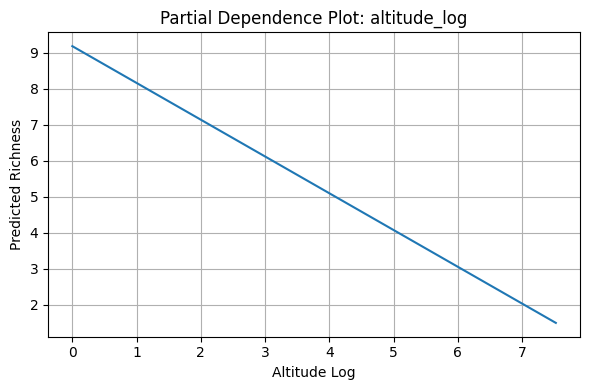

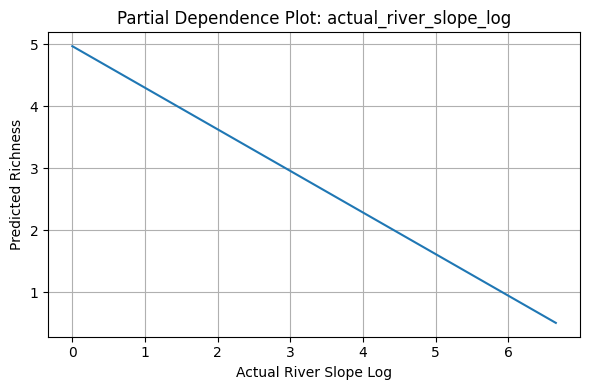

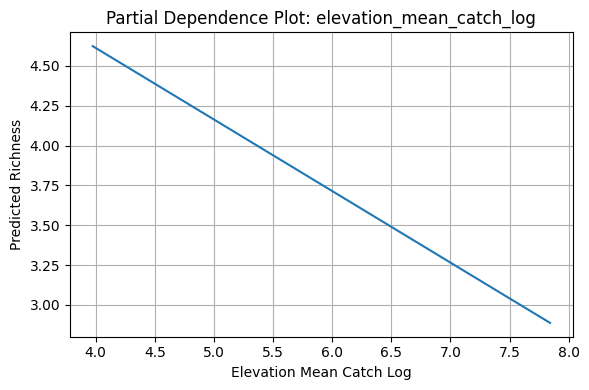

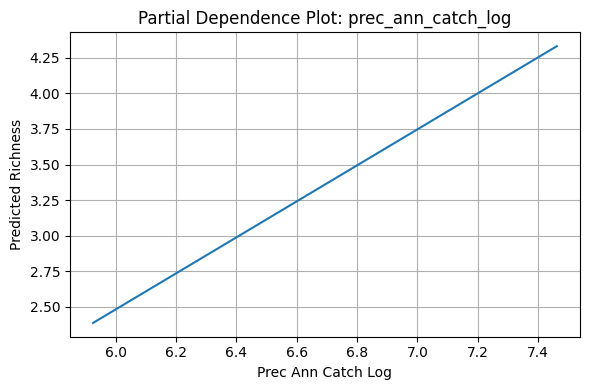

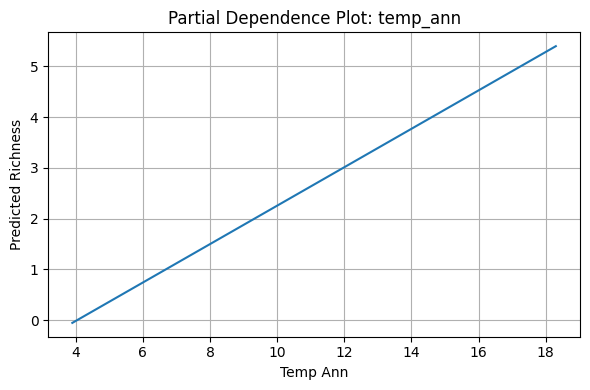

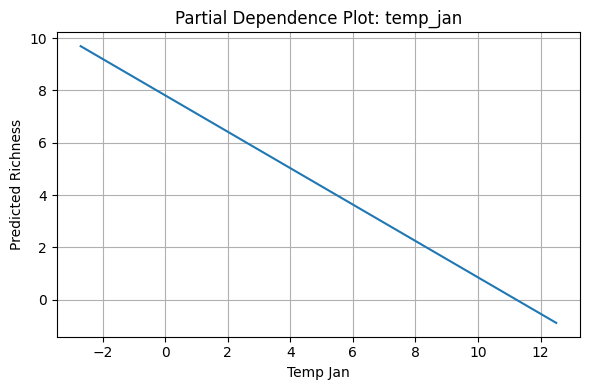

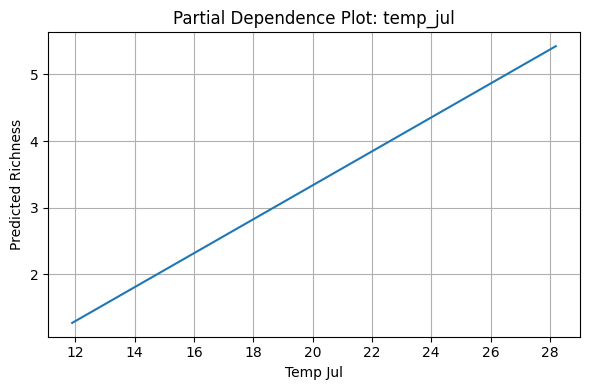

In [10]:
# --- Partial Dependence Plots ---
from copy import deepcopy

# Create PDP for each predictor
for var in existing_predictors:
    # Create a copy of the dataframe with all predictors at their mean
    pdp_data = pd.DataFrame()
    for col in existing_predictors:
        pdp_data[col] = [df[col].mean()] * 100

    # Vary the current variable over its observed range
    pdp_data[var] = np.linspace(df[var].min(), df[var].max(), 100)

    # Predict richness
    pdp_data['predicted_richness'] = multi_model.predict(pdp_data)

    # Plot
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=pdp_data, x=var, y='predicted_richness')
    plt.title(f'Partial Dependence Plot: {var}')
    plt.xlabel(var.replace('_', ' ').title())
    plt.ylabel('Predicted Richness')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Part 3

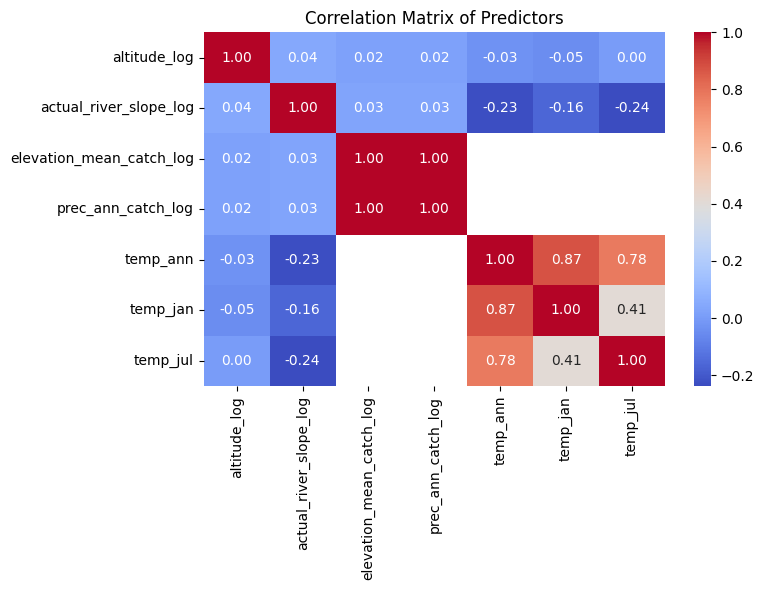

Variance Inflation Factors (VIF):


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Variable,VIF
0,altitude_log,1.004068
1,actual_river_slope_log,1.067571
2,elevation_mean_catch_log,0.000000
3,prec_ann_catch_log,0.000000
4,temp_ann,52.902022
5,temp_jan,24.789537
6,temp_jul,14.888208


Parsimonious Model Summary (VIF ≤ 5):
                            OLS Regression Results                            
Dep. Variable:               richness   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     21.79
Date:                Tue, 13 May 2025   Prob (F-statistic):           5.14e-14
Time:                        18:00:42   Log-Likelihood:                -12280.
No. Observations:                5011   AIC:                         2.457e+04
Df Residuals:                    5007   BIC:                         2.459e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [16]:
# 3. Multicollinearity Diagnosis and Parsimonious Model

from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- Define initial predictor list ---
multi_predictors = [
    'altitude_log',
    'actual_river_slope_log',
    'elevation_mean_catch_log',
    'prec_ann_catch_log',
    'temp_ann',
    'temp_jan',
    'temp_jul'
]

# --- Ensure only existing predictors are used ---
existing_predictors = [var for var in multi_predictors if var in df.columns]

# --- Check correlation matrix (optional but informative) ---
plt.figure(figsize=(8, 6))
corr_matrix = df[existing_predictors].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Predictors")
plt.tight_layout()
plt.show()

# --- Create DataFrame for VIF calculation ---
X = df[existing_predictors].dropna().copy()
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# --- Display VIF table ---
print("Variance Inflation Factors (VIF):")
display(vif_data)

# --- Select variables with VIF ≤ 5 (excluding constant) ---
reduced_predictors = vif_data[(vif_data['VIF'] <= 5) & (vif_data['Variable'] != 'const')]['Variable'].tolist()

# --- Fit the parsimonious model ---
if reduced_predictors:
    formula_reduced = "richness ~ " + " + ".join(reduced_predictors)
    reduced_model = smf.ols(formula=formula_reduced, data=df).fit()

    print("Parsimonious Model Summary (VIF ≤ 5):")
    print(reduced_model.summary())
else:
    print("No predictors passed the VIF ≤ 5 threshold — model not refitted.")


### Interpretation of Parsimonious Model after Multicollinearity Diagnosis

In this step, we addressed potential multicollinearity by calculating Variance Inflation Factors (VIF) and fitting a reduced (parsimonious) model using only variables with VIF ≤ 5.

---

#### Collinearity Check (VIF)

- The correlation matrix showed strong correlation between `temp_ann`, `temp_jan`, and `temp_jul` (up to 0.87).
- VIF values confirmed multicollinearity:
  - `temp_ann`: 52.00
  - `temp_jan`: 24.79
  - `temp_jul`: 14.88

These high VIFs indicated that the temperature variables are redundant when included together.

- Variables with VIF = 0 (e.g., `elevation_mean_catch_log`) are mathematically collinear (likely due to being equal or derived from others). These were excluded from the model.

---

#### Parsimonious Model Fit

- R-squared: 0.013  
- Adjusted R-squared: 0.012

Although the explained variance is lower than the full model (R² = 0.103), the model is now more stable and interpretable.

---

#### Significant Predictors in the Reduced Model

- `actual_river_slope_log`: Coef = -0.717, p < 0.001  
- `elevation_mean_catch_log`: Coef = 0.400, p < 0.001  
- `prec_ann_catch_log`: Coef = 0.400, p < 0.001

These three variables remain statistically significant and now contribute without multicollinearity interference.

---

#### Non-Significant Predictor

- `altitude_log`: Coef = -0.368, p = 0.713

Although included in the model due to acceptable VIF, altitude does not show a significant contribution in the presence of the other predictors.

---

#### Conclusion

The parsimonious model is more reliable statistically and free from collinearity issues. While it explains less variance, it isolates the unique effect of each retained predictor more accurately.
